In [120]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

In [121]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [122]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)

In [123]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'dist', 'speed', 'pickup_hour',
       'dropoff_hour', 'dayofweek'],
      dtype='object')

In [132]:
tidydata = df.pivot_table(index='pickup_hour', 
                          columns='dayofweek', 
                          values='speed', 
                          aggfunc = 'mean')\
.stack().reset_index().rename({0: 'speed_mean'},axis=1)
tidydata['dayofweek'] = tidydata['dayofweek'].map({0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'})


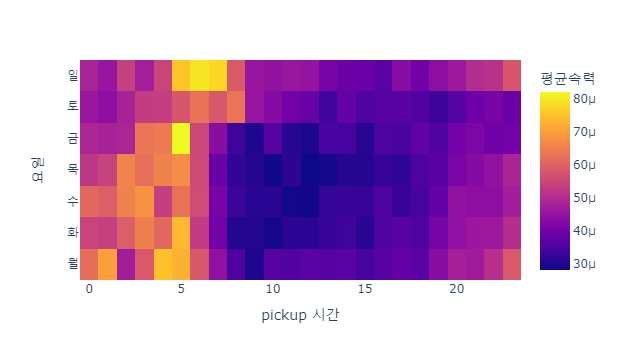

In [133]:
fig = px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='speed_mean',
    nbinsx=24,
    nbinsy=7
)
# fig.update_traces(colorbar=dict(title='평균속력'))
# fig.update_xaxes(title_text='pickup 시간')
# fig.update_yaxes(title_text='요일')

fig.update_layout(xaxis={'title':'pickup 시간'},
                 yaxis={'title':'요일'},
                 coloraxis_colorbar={'title':'평균속력'})

In [134]:
tidydata2 = df.pivot_table(index='pickup_hour', 
                           columns='dayofweek', 
                           values='dist', 
                           aggfunc = 'mean')\
.stack().reset_index().rename({0: 'dist_mean'},axis=1)
tidydata2['dayofweek'] = tidydata2['dayofweek'].map({0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'})


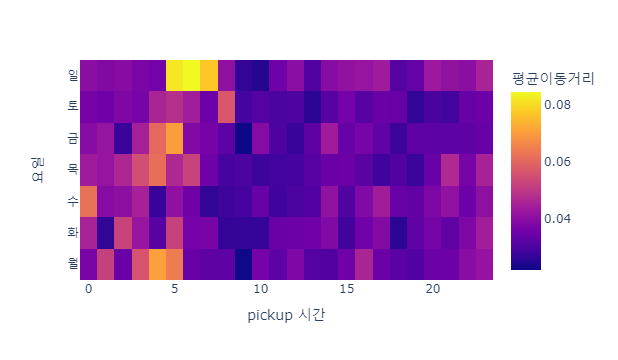

In [135]:
fig = px.density_heatmap(
    data_frame=tidydata2,
    x='pickup_hour',
    y='dayofweek',
    z='dist_mean',
    nbinsx=24,
    nbinsy=7,
)
# fig.update_traces(colorbar=dict(title='평균속력'))
# fig.update_xaxes(title_text='pickup 시간')
# fig.update_yaxes(title_text='요일')

fig.update_layout(xaxis={'title':'pickup 시간'},
                 yaxis={'title':'요일'},
                 coloraxis_colorbar={'title':'평균이동거리'})

In [136]:
pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_small.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_small.groupby('id')]).reset_index(drop=True)
df_feature_small2 = df_left.merge(df_right)

In [137]:
tidydata3 = df_feature_small2.assign(speed_cut = pd.qcut(df_feature_small2['speed'], 4,labels=['매우느림','조금느림','조금빠름','매우빠름']))\
.sort_values('speed_cut')

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



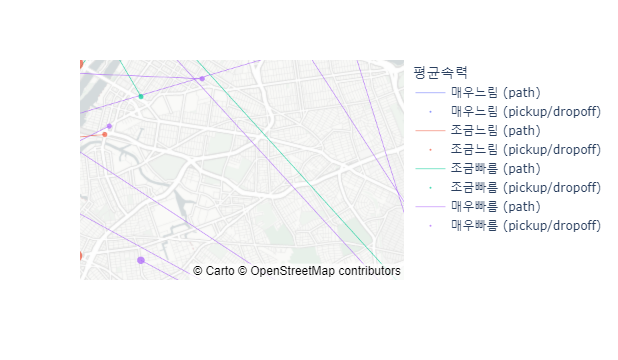

In [148]:
fig3 = px.line_mapbox(
    data_frame=tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = 'speed_cut',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,   
)
scatter_data = px.scatter_mapbox(
    data_frame=tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'speed_cut',
    #---#
    mapbox_style = 'carto-positron',
    zoom=11, 
).data 
for sd in scatter_data: 
    fig3.add_trace(sd)
fig3.update_traces(
    line={
        'width':0.5
    },
    opacity=1.0
)
fig3.update_layout(legend_title='평균속력')
for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['name'] = fig3.data[i]['name']+' (path)'
    else :
        fig3.data[i]['name'] = fig3.data[i]['name']+' (pickup/dropoff)'
        
fig3.show(config={'scrollZoom':False})